# Profit Curves

> skip_exec: true


In [ ]:
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)

PROJECT_ROOT = Path.cwd().parent.parent

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0


## Getting the data


The dataset is from the [Telco Customer Churn Kaggle Competition](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). The target is the simple binary outcome in the `Churn` column.


In [ ]:
data = pd.read_csv(f"{PROJECT_ROOT}/data/WA_Fn-UseC_-Telco-Customer-Churn.csv", low_memory=False)


In [ ]:
data


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
target = "Churn"

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1), data[target] == "Yes", test_size=0.2, random_state=0
)
cols_to_use = [
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
]


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "one_hot",
            OneHotEncoder(),
            make_column_selector(dtype_include="object"),
        ),
    ],
    remainder="passthrough",  # Leave numerical variables unchanged
)

pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier())])
pipeline.fit(X_train[cols_to_use], y_train)
y_pred = pipeline.predict_proba(X_test[cols_to_use])[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
log_loss_val = log_loss(y_test, y_pred)

In [ ]:
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(f"GINI: {2 * roc_auc_score(y_test, y_pred) - 1}")
print(f"Log loss: {log_loss(y_test, y_pred)}")

ROC AUC Score: 0.8152565467986469
GINI: 0.6305130935972938
Log loss: 0.4718305882942505


We can plot the distribution of the model's predictions like so


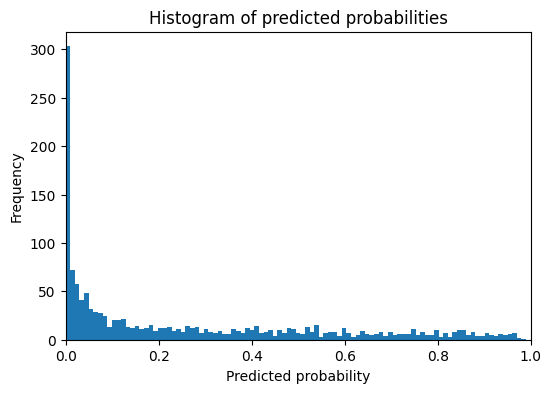

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(y_pred, bins=100, label="Predictions")
ax.set_xlim(0, 1)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of predicted probabilities")
plt.show()


Picking a decision threshold from here is not always obvious. We can see the trade offs by plotting confusion matrices for a range of thresholds.


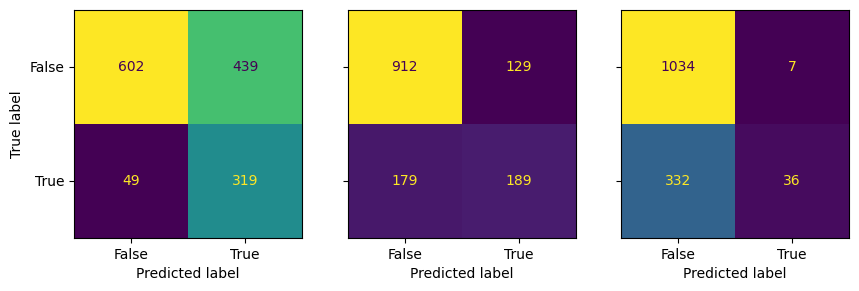

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for i, threshold in enumerate([0.1, 0.5, 0.9]):
    cm = confusion_matrix(y_test, (y_pred > threshold).astype(int))
    ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_).plot(ax=axes[i], colorbar=False)
    if i != 0:
        axes[i].set_ylabel(None)
plt.show()

We can use a `payoff matrix` to help us decide which threshold to use. This is a table that shows how much retaining a customer is worth to us, and how much it costs us to retain them.

For instance, say the matrix looks like the one below:


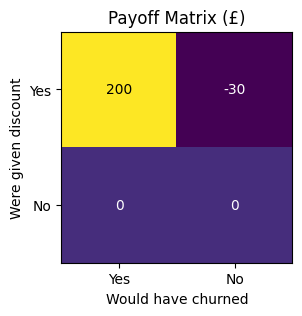

In [ ]:
payoff_matrix = np.array(
    [
        [200, -30],
        [0, 0],
    ]
)

fig, ax = plt.subplots(figsize=(5, 3))
norm = plt.Normalize(vmin=payoff_matrix.min(), vmax=payoff_matrix.max())
colormap = plt.cm.viridis

ax.imshow(payoff_matrix, cmap="viridis", norm=norm)
ax.set_xticks(np.arange(2), ["Yes", "No"])
ax.set_xlabel("Would have churned")
ax.set_yticks(np.arange(2), ["Yes", "No"])
ax.set_ylabel("Were given discount")
ax.set_title("Payoff Matrix (£)")

for i in range(payoff_matrix.shape[0]):
    for j in range(payoff_matrix.shape[1]):
        cell_value = payoff_matrix[i, j]
        text_color = "black" if np.array(colormap(norm(cell_value))[:3]).mean() > 0.5 else "white"
        ax.text(j, i, cell_value, ha="center", va="center", color=text_color)

plt.show()

In [ ]:
def profit_curve(y_true: np.ndarray, y_pred: np.ndarray, payoff_matrix: np.ndarray, n_points: int = 101) -> Tuple:
    """
    Calculate profit curve for a binary classifier.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        payoff_matrix (array-like): Payoff matrix.
        n_points (int): Number of points to calculate.

    Returns:
        tuple: x and y values for the profit curve.
    """

    thresholds = np.linspace(0, 1, n_points)
    profits = []
    for threshold in thresholds:
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        cm = confusion_matrix(y_true, y_pred_binary)
        profit = (cm * payoff_matrix).sum()
        profits.append(profit)
    return thresholds, profits


In [ ]:
# Costs $80 to give discount to a customer who will not churn
# Worth $200 to give discount to a customer who will otherwise churn
payoff_matrix = np.array([[0, -80], [0, 200]])
first_thresholds, first_profits = profit_curve(y_test, y_pred, payoff_matrix)


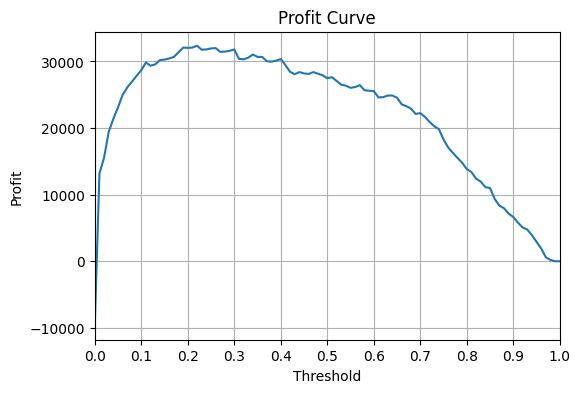

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(first_thresholds, first_profits)
ax.set_xlabel("Threshold")
ax.set_ylabel("Profit")
ax.set_title("Profit Curve")
ax.set_xlim([0, 1])
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.grid(True)
plt.show()


In [ ]:
def find_best_threshold_and_profit(thresholds, profits):
    """Find the best threshold and profit.

    Args:
        thresholds (array-like): Threshold values.
        profits (array-like): Profit values.

    Returns:
        tuple: Best threshold and profit.
    """
    best_profit = max(profits)
    best_threshold = thresholds[profits.index(best_profit)]
    return best_threshold, best_profit


best_thresh, best_profits = find_best_threshold_and_profit(first_thresholds, first_profits)

print(f"Ideal threshold is {best_thresh:.2f} which yields profits of ${best_profits:.0f}")


Ideal threshold is 0.22 which yields profits of $32360
